# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План исследования**

1. Изучение датафрейма с помощью методов info(), head() и гистограмм.
На этом этапе открою файл, узнаю его размер и содержание, а затем определю ключевые проблемы, которые нужно будет решить на предобработке.


2. Предобработка данных с помощью .isnull(), .unique(), .replace()
Выясню, сколько в таблице пропущенных значений и определю правила по их предобработке. Затем проверю датафрейм на дубликаты и избавлюсь от них, а заодно от пропущенных знаний, которые смогут повлиять на качество анализа. Кроме того, скорректирую данные по типам там, где потребуется. 


3. Исследовательский анализ данных
Изучу с помощью гистограмм распределения значений для ключевых факторов по объектам. Уточню природу аномальных значений. С помощью гистограмм и значений корреляции определю влияние отдельных факторов на общую стоимость квартиры. Изучу, как быстро продавались квартиры по годам, месяцам и дням недели.


4. Подведу итоги по проекту.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

#### Изучение файла

При первой попытке открыть файл мы видим, что у датафрейма есть разделитель \t. Используем его в значении 'sep', чтобы корректно открыть таблицу. Вместо функции print() используем display(): подсмотрел ее в интернете, вывод данных с помощью нее мне кажется более читабельным.

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')
except FileNotFoundError:
    data = pd.read_csv('/Users/macbookpro/Downloads/real_estate_data.csv', sep='\t', decimal='.')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Посмотрим общую информацию о датафрейме и сразу посчитаем, по какому числу населенных пунктов у нас есть данные: это пригодится на следующем этапе обработки. Заодно построим гистограммы по каждой колонке датафрейма, чтобы оценить их более наглядно.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

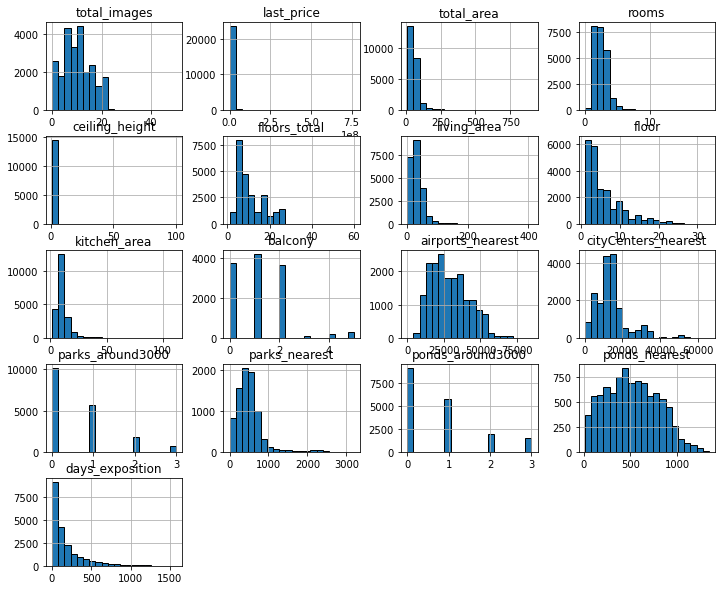

In [3]:
print(data.info())
print()
print(f"Число уникальных названий населенных пунктов: {data['locality_name'].nunique()}")

data.hist(figsize=(12, 10), grid=True, edgecolor='black', bins=20)
plt.show()

#### Вывод перед предобработкой данных

При изучении первых пяти строк датафрейма и гистограмм мы видим ряд проблем, которые нужно решить на предобработке:
1. В 14 из 21 колонки есть пропущенные данные. Больше всего пропусков в is_apartment, parks_nearest, ponds_nearest, balcony, ceiling_height. Это не особо критично: вижу по заданию, что с is_apartment, parks_nearest, ponds_nearest работать не будем. Balcony и ceiling_height обработаю на следующем этапе.
2. В parks_around3000, rooms, floors_total и ponds_around3000 неверные значения данных pandas: float вместо int64. Не может быть 2.5 парков в радиусе 3 км или 2.5 комнаты.
3. Вид данных в first_day_exposition - object вместо datetime64.
4. Очень много уникальных названий населенных пунктов: это значит, что есть вероятност названий-дубликатов.
5. По всем гистограммам, кроме ponds_nearest, airports_nearest и total_images видно, что распределение данных во многих из них нельзя назвать нормальным. Это связано с пробелами в данных и аномалиями, которые мы попробуем устранить при предобработке.

### Предобработка данных

#### Найдите и изучите пропущенные значения в столбцах

Сперва посмотрим, сколько пропущенных значений в каждой колонке датафрейма.

In [4]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Заполним пропущенные значения там, где это возможно. Правила: 

1. Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски заменим на число 0.
2. Скорее всего, в пропущенных значениях parks_around3000 и ponds_around3000 в радиусе 3 км попросту нет парков или водоемов. Такие пропуски также заменим на 0: нам они в рамках текущей работы не понадобятся, но глаз могут мозолить.
3. В пропущенных значениях в airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest оставим пропуски. По существующим значениям видно, что в датафрейме есть и не самые близкие расстояния: например, в первой строке cityCenters_nearest стоит 18603 м. 
4. В ceiling_height посчитаем медианное значение, исключив из подсчета аномально высокие показатели (потолок в квартире не может достигать 10 метров). Регламента высоты потолков нет, но новые дома строятся с потолками не выше 3.2 м (источник: https://spb.101novostroyka.ru/info/standartnaya-vysota-potolkov-normativy). Это значение мы и возьмем в качестве границы нормы.
5. В is_apartment пропуски заменим на False: скорее всего, такие данные относятся к старому жилому фонду, где нет апартаментов, или понятие "апартаменты" появилось уже после снятия объявления.
6. Для пропусков по жилой площади и площадки кухни посчитаем средние значения от всей площади по всему датафрейму.

Если логичную замену предложить невозможно, то оставим пропуски. 

In [5]:
data[['balcony', 
      'parks_around3000', 
      'ponds_around3000']] = data[['balcony', 
                                   'parks_around3000', 
                                   'ponds_around3000']].fillna(0)

data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
normal_ceiling = data.query('ceiling_height <= 3.2')
data['ceiling_height'] = data['ceiling_height'].fillna(
    normal_ceiling['ceiling_height'].median())

living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)
data['is_apartment'] = data['is_apartment'].fillna(False)
print(data.isnull().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [6]:
data = data.dropna(subset=['floors_total', 'locality_name'])

data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

#### Укажите причины, которые могли привести к пропускам в данны

**Высота потолка:** в ceiling_height пропуски можно объяснить человеческим фактором: возможно, продавцы недвижимости забыли заполнить эту информацию. Кроме того, в столбце есть аномально высокие значения выше четырех метров. Вероятно, эти значения связаны с ошибкой форматирования при вводе: например, продавец вводил сантиметры вместо метров.

**Жилая площадь и площадь кухни:** скорее всего, часть продавцов недвижимости посчитала эту информацию ненужной и указывала только общую площадь. Мы видим, что в колонке с общей площадью (total_area) пропусков нет. 

**Апартаменты:** это относительно новое для рынка недвижимости в России понятие, которое относится к новостройкам, а не к старому жилому фонду. Поэтому отсутствие таких значений можно объяснить или давностью объявления, или тем, что объявления относятся к старому жилому фонду.

**Название населенного пункта:** мы видим, что таких пропусков относительно немного: всего 49. В первую очередь они связаны с человеческим фактором: скорее всего, продавцы просто забыли заполнить эту информацию.

**Близость к аэропорту, центру города, паркам и водоемам:** вероятно, пропуски в этих колонках можно объяснить или человеческим фактором (продацы поленились или не захотели указывать эти значения), или дальностью расположения объекта недвижимости к этим сущностям.

**Сколько дней было размещено объявление:** здесь я вижу две возможные причины пропусков: или объявление еще висит (значит, время от публикации до снятия еще нельзя рассчитать), или причина в технической ошибке (данные пропали при выгрузке датафрейма).

#### Рассмотрите типы данных в каждом столбце

Еще раз посмотрим на общую информацию по датафрейму:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

#### Найдите столбцы, в которых нужно изменить тип данных, и преобразуйте их

Мы видим, что тип данных некорректен в следующих столбцах:

1. first_day_exposition должен быть dataframe64, а не object, тк внутри столбца дата публикации объявления
2. floors_total и balcony должен быть int64, а не float64: количество этажей и балконов не может быть дробным значением. Пока изменим только balcony, тк в floors_total есть пропущенные значения
3. parks_around3000 и ponds_around3000 должны быть int64, а не float64: количество парков и водоемов в радиусе 3 км не может быть дробным значением
4. days_exposition должно быть int64, а не float64: количество парков и водоемов в радиусе 3 км не может быть дробным значением

Преобразуем типы данных в тех столбцах, где это необходимо:

In [8]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['balcony'] = data['balcony'].astype('int64')
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')
data[['parks_around3000', 'ponds_around3000']] = data[['parks_around3000', 'ponds_around3000']].astype('int64')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

In [9]:
data['floors_total'] = data['floors_total'].astype('int64')

#### Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты

Сперва посмотрим все уникальные значения по локациям:

In [10]:
print(data.locality_name.unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Вижу, что есть много неявных дубликатов по типу "поселок" и "садовое товарищество". Устраню их и сведу дубликаты к одному виду с помощью replace(). Кроме того, при обработке заменю 'ё' на 'е'.

In [11]:
data.locality_name = (
    data.locality_name
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'городской поселок', 'коттеджный поселок', 
              'поселок станции', 'поселок при железнодорожной станции'], 'поселок', regex=True)
    .replace('садоводческое некоммерческое товарищество', 'садовое товарищество', regex=True)
) 

print(data.locality_name.unique())

['Санкт-Петербург' 'поселок Шушары' 'поселок Янино-1' 'поселок Парголово'
 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Коммунар' 'Колпино' 'поселок Красный Бор' 'Гатчина'
 'деревня Федоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'поселок Металлострой' 'поселок Лебяжье'
 'поселок Сиверский' 'поселок Молодцово' 'поселок Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'поселок Романовка' 'поселок Бугры' 'поселок Рощино' 'Кириши'
 'Луга' 'Волосово'

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V2 ✔️</b>

Отлично! 👍

****Промежуточный вывод по предобработке****

1. Мы обработали пропущенные значения по числу балконов, значениям в parks_around3000, ponds_around3000, airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest. В ceiling_height посчитали медианное значение и заменили пропуски на него, исключив из подсчета аномально высокие показатели. Еще привели is_apartment к булеву типу в пропусках, посчитали средние значения для пропусков по жилой площади и площади кухни.


2. Подготовили гипотезы по возможным причинам пропусков в данных. Например, в случае с высотой потолка пропуски можно объяснить человеческим фактором: возможно, продавцы недвижимости забыли заполнить эту информацию. Кроме того, в столбце есть аномально высокие значения выше четырех метров. Вероятно, эти значения связаны с ошибкой форматирования при вводе: например, продавец вводил сантиметры вместо метров.


3. Привели к корректному типу данные по датафрейму: например, first_day_exposition заменили на dataframe64 вместо object, тк внутри столбца дата публикации объявления.


4. Выявили, что внутри столбца с локациями много неявных дубликатов ("поселок" и коттеджный поселок"), обработали их.

### Шаг 3. Добавьте в таблицу новые столбцы 

Посчитаю среднюю цену одного кв м и округлю ее до двух знаком после запятой. Добавлю новые столбцы с dataframe по дню, году и месяцу публикации объявления: данные возьму из first_day_exposition. Посчитаю расстояние до центра Петербурга в км вместо м, округлю и сразу приведу к типу целых чисел.

Создам функцию, которая будет определять категорию недвижимости по ее этажу: есть категории "первый", "последний" и "другой. Данные про этаж возьму из совпадения/несовпадения с floors_total.

In [12]:
meter_price_info = data['last_price'] / data['total_area']
data['meter_price'] = round(meter_price_info, 2)
data['day'] = data['first_day_exposition'].dt.weekday
data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
data['centre_distance'] = (data['cityCenters_nearest'] / 1000).round().astype('int')
data['last_price'] = data['last_price'].astype('int')

def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
data['floor_category'] = data.apply(floor_category, axis = 1)

display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,day,year,month,centre_distance,floor_category
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,0,120370.37,3,2019,3,16,другой
1,7,3350000,40.4,2018-12-04,1,2.64,11,18.600000,1,False,...,NaN,0,NaN,81,82920.79,1,2018,12,19,первый
2,10,5196000,56.0,2015-08-20,2,2.64,5,34.300000,4,False,...,90.0,2,574.0,558,92785.71,3,2015,8,14,другой
3,0,64900000,159.0,2015-07-24,3,2.64,14,90.785766,9,False,...,84.0,3,234.0,424,408176.10,4,2015,7,7,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121,100000.00,1,2018,6,8,другой


In [13]:
data[['floor', 'floors_total', 'floor_category']].sample(10)

,floor,floors_total,floor_category
4072,2,5,другой
19373,4,9,другой
14808,4,9,другой
11337,10,11,другой
13430,1,5,первый
11238,2,3,другой
22196,1,5,первый
7361,10,25,другой
14186,23,28,другой
11896,18,23,другой


****Промежуточный вывод по работе с новыми столбцами****

В результате этого этапа добавили в датафрейм несколько новых столбцов. Они позволят удобнее и эффективнее работать с данными при исследовательском анализе. Среди таких столбцов – данные по году, месяцу и дате публикации объявления, расстояние до центра Петербурга в километрах и тип недвижимости по этажу.

### Проведите исследовательский анализ данных

Сперва изучим показатели площади (общая, жилая, кухни) с помощью гистограмм и метода describe(). Строить буду в субплотах, чтобы вывести три графика на одной строке для удобства и визуальной составляющей. Изучу показатели методом describe().

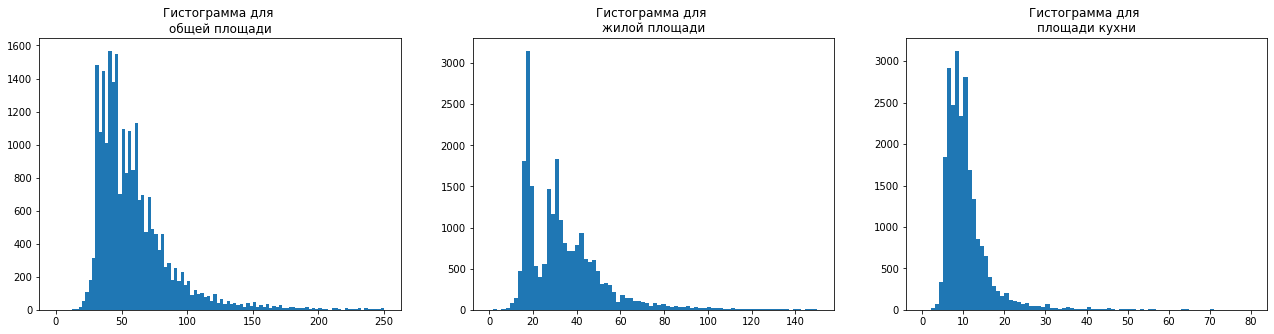

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

count    23565.000000
mean        34.591303
std         22.372806
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

count    23565.000000
mean        10.500277
std          6.038042
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


In [14]:
_, ax = plt.subplots(1, 3, figsize=(22, 5))

ax[0].hist(data['total_area'], bins=100, range=(0,250))
ax[0].set_title('Гистограмма для \nобщей площади')
ax[1].hist(data['living_area'], bins = 80, range=(0,150))
ax[1].set_title('Гистограмма для \nжилой площади')
ax[2].hist(data['kitchen_area'], bins = 80, range=(0,80))
ax[2].set_title('Гистограмма для \nплощади кухни')
   
plt.show()
print(data.total_area.describe())
print()
print(data.living_area.describe())
print()
print(data.kitchen_area.describe())

По гистограмме мы видим, что распределение общей площади близко к нормальному: есть небольшой выбивающийся из нормального распределения показатель на 25 метрах, который похож на второй пик. Однако в целом он не превышает общий пик по значению. В случае с жилой площадью распределение по гистограмме выбивается из нормального сильнее: есть несколько ярко выраженных пиков.

Метод describe() показал, что в общей площади есть аномальные значения: максимальная площадь, например, в 900 кв м, а стандартное отклонение, конечно, из-за этого значительно превышает 1. Среднее значение при этом адекватное, 60 кв м, как и показатели по квартилям (40, 52 и 69.7 кв м). Похожая картина по жилой площади и площади кухни: максимальная жилая площадь в 409 кв м, кухни - в 112. 

Предполагаю, что аномальные значения вызваны человеческим фактором: ошибкой при внесении данных (должно быть 90 м вместо 900 м). Тем не менее, анализ недвижимости Петербурга показал, что на рынке есть квартиры с соотносимой площадью, например, в 631 метр (https://mir24.tv/news/16343727/nazvany-razmery-samoi-bolshoi-i-samoi-malenkoi-kvartir-v-peterburge). Поэтому самостоятельно исправлять эти значения до обсуждения с аналитиками не стал бы, а просто буду работать со строками, где значения общей площади будут меньше или равны 250 метров.

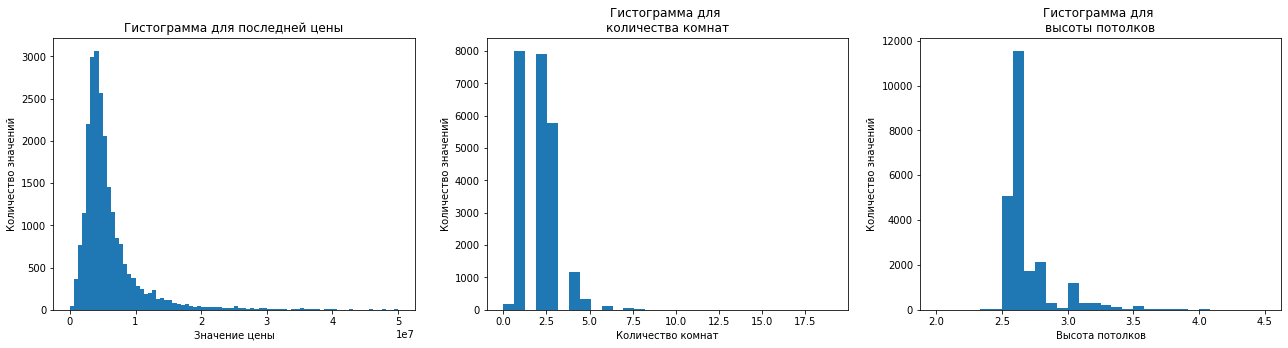

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

count    23565.000000
mean         2.720675
std          0.991328
min          1.000000
25%          2.600000
50%          2.640000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


In [15]:
_, ax = plt.subplots(1, 3, figsize=(22, 5))

#в гистограмме цены выводятся в экспоненциальной записи, видимо, из-за их размера
ax[0].hist(data['last_price'], bins=80, range=(0,50000000))
ax[0].set_title('Гистограмма для последней цены')
ax[0].set_xlabel('Значение цены')
ax[0].set_ylabel('Количество значений')

ax[1].hist(data['rooms'], bins = 30)
ax[1].set_title('Гистограмма для \nколичества комнат')
ax[1].set_xlabel('Количество комнат')
ax[1].set_ylabel('Количество значений')

#ограничим размер потолков нормальными значениями
ax[2].hist(data['ceiling_height'], bins = 30, range=(2,4.5))
ax[2].set_title('Гистограмма для \nвысоты потолков')
ax[2].set_xlabel('Высота потолков')
ax[2].set_ylabel('Количество значений')

plt.show()
print(data.last_price.describe())
print()
print(data.rooms.describe())
print()
print(data.ceiling_height.describe())

Мы видим, что по гистограмме распределение цены соответствует нормальным значениям. Тем не менее, describe() показал, что есть аномальные показатели: минимальная цена в 12.2 тысячи рублей и максимальная в 763 млн. При дальнейшей работе с этими данными буду ограничиваться выборкой от 1 млн до 30 млн рублей, тк значения ниже и выше могут быть аномальными. По гистограмме видно, что за пределами этой суммы недвижимости почти нет.

С данными по комнатам и по высоте потолков поступлю аналогичным образом: при анализе буду брать квартиры с максимумом комнат в 5 и высотой потолков в 4 м, тк есть аномальные значения с 19 комнатами и 100 м высоты потолка. Даже если учесть, что при вводе высоты потолков мог сыграть человеческий фактор и 100 м на самом деле 10 м, это все равно нереалистичные показатели.  

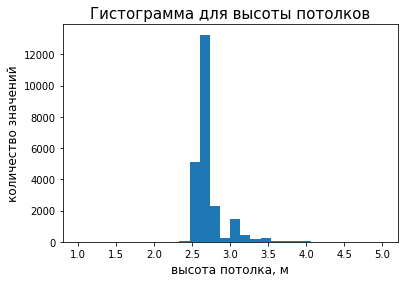

In [16]:
#добавляем условие: если высота потолка больше или равна 25, делим ее на 10:
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x/10 if x>=25 else x)

plt.hist(data['ceiling_height'], bins=30, range =(1,5))
plt.title('Гистограмма для высоты потолков', fontsize=15)
plt.xlabel('высота потолка, м', fontsize=12)
plt.ylabel('количество значений', fontsize=12)
plt.show()

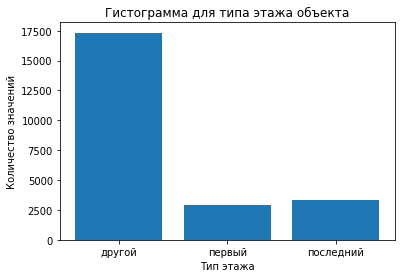

In [17]:
#посчитаем количество строк по колонке без пробелов total_area,
#передадим его вместо параметра height

plt.bar(['другой', 'первый', 'последний'],
        data.groupby('floor_category')['total_area'].count())
plt.title('Гистограмма для типа этажа объекта')
plt.xlabel('Тип этажа')
plt.ylabel('Количество значений')
plt.show()

Мы видим, что большая часть квартир приходится на показатель другой (более 17,5 тысяч значений).

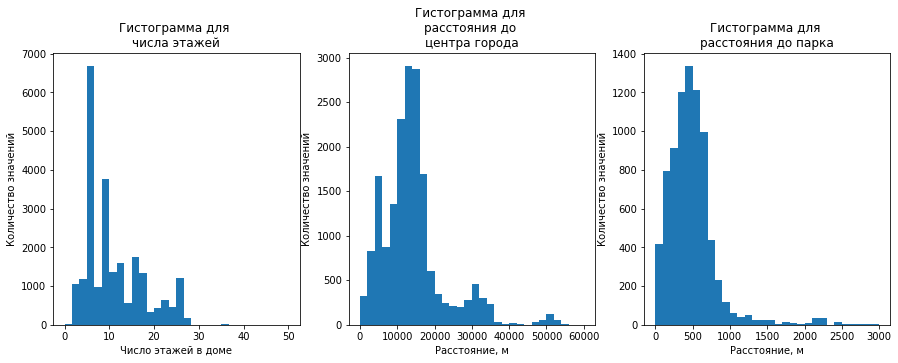

count    23565.000000
mean        10.675875
std          6.594823
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

count    23565.000000
mean     10879.530617
std       9639.346166
min          0.000000
25%       2186.000000
50%      11246.000000
75%      15237.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

count    8030.000000
mean      490.580448
std       341.572956
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


In [18]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(data['floors_total'], bins=30, range=(0,50))
ax[0].set_title('Гистограмма для \nчисла этажей')
ax[0].set_xlabel('Число этажей в доме')
ax[0].set_ylabel('Количество значений')

ax[1].hist(data['cityCenters_nearest'], bins = 30, range=(1,60000))
ax[1].set_title('Гистограмма для \nрасстояния до \nцентра города')
ax[1].set_xlabel('Расстояние, м')
ax[1].set_ylabel('Количество значений')

ax[2].hist(data['parks_nearest'], bins = 30, range=(0,3000))
ax[2].set_title('Гистограмма для \nрасстояния до парка')
ax[2].set_xlabel('Расстояние, м')
ax[2].set_ylabel('Количество значений')
           
plt.show()
print(data.floors_total.describe())
print()
print(data.cityCenters_nearest.describe())
print()
print(data.parks_nearest.describe())

 Создадим массив good_data с данными, которые будут меньше выбиваться в аномалию. Правила:
 1. Максимум комнат = 5
 2. Максимум высоты потолков = 4 м
 3. Максимум общей площади = 250 м
 4. Максимум цены = 30000000 
 
 Заодно не будем брать строки из датафрейма, где нет значения по локации, количеству комнат и значения по количеству этажей в доме. 
 
Затем проверим, какой процент строк попадет под наши правила.

In [19]:
max_area = 250
max_price = 30000000
max_room = 5
good_data = (
    data.query('total_area <= @max_area and last_price <= @max_price and rooms <= @max_room and rooms != 0 and locality_name != 0 and floors_total != 0')       
)

data_check =  (len(good_data) / len(data))
print(f'В выборку хороших данных попали {"{:.0%}".format(data_check)} строк из общего массива data')

В выборку хороших данных попали 97% строк из общего массива data


#### Изучите, как быстро продавались квартиры (столбец days_exposition). 

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

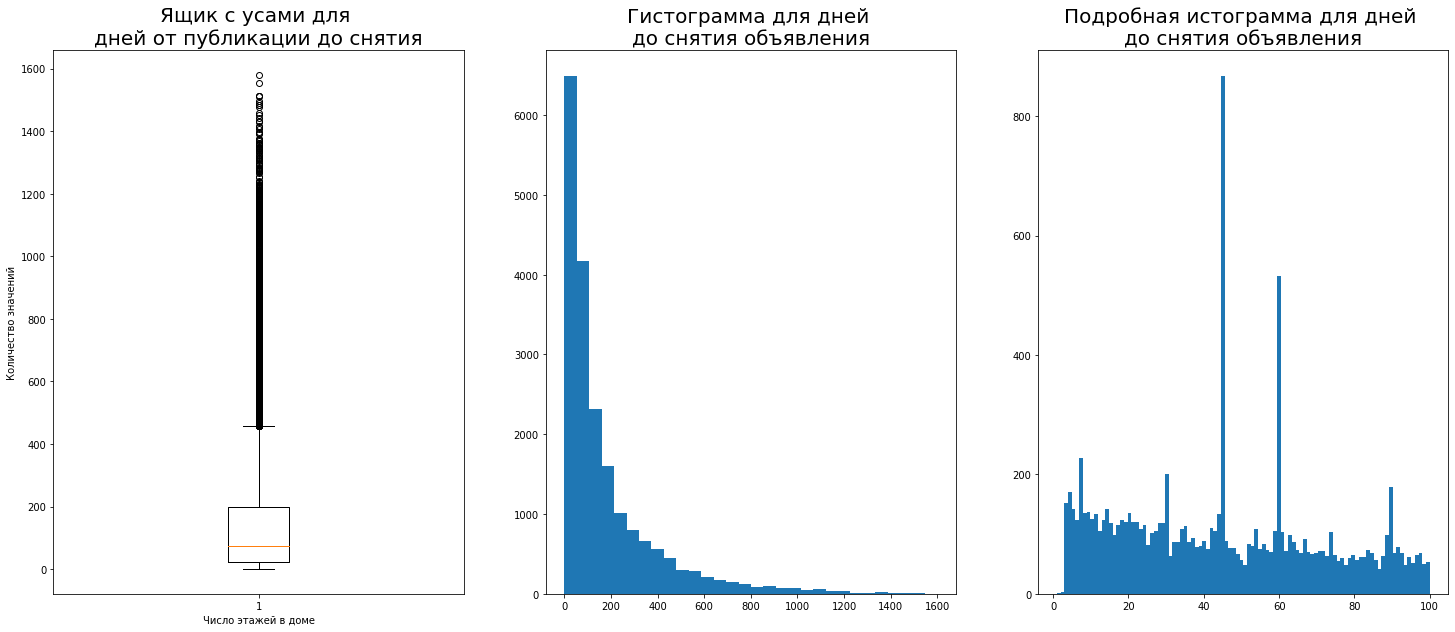

In [20]:
_, ax = plt.subplots(1, 3, figsize=(25, 10))

ax[0].boxplot(good_data['days_exposition'])
ax[0].set_title('Ящик с усами для \nдней от публикации до снятия', fontsize=20)
ax[0].set_xlabel('Число этажей в доме')
ax[0].set_ylabel('Количество значений')

ax[1].hist(good_data['days_exposition'], bins = 30, range = (1,1600))
ax[1].set_title('Гистограмма для дней \nдо снятия объявления', fontsize=20)
ax[2].hist(good_data['days_exposition'], bins = 100, range = (1,100))
ax[2].set_title('Подробная истограмма для дней \nдо снятия объявления', fontsize=20)
data[data['days_exposition']!=0]['days_exposition'].describe()

Распределение значений на гистограмме является распределением Пуассона, которое характеризует число событий на единицу времени. Медианное время от публикации до снятия объявления - 90 дней: это мы видим по диаграмме ящика с усами, а среднее при отброшенных нулевых значениях - 180. Судя по графику ящика с усами, необычайно долгими можно считать объявления, которые висят более 450 дней, а быстрыми - продажи за срок менее 90 дней. Нормальными при этом являются значения по продаже от 91 до 450 дней.

При этом мы можем только предположить, что эти показатели отображают срок продажи квартиры: владельцы могут снять объявление в том числе из-за отсутствия спроса на их недвижимость или из-за изменения планов.

Отдельно посмотрим более подробно на дни по снятиям публикации: видим, что аномальные значения с пиками приходятся на 45, 60 и 90 дней. Предположу, что в эти дни публикации улетают в автоматически снятые по правилам сервиса или владельцы решают создать новое объявление и закрыть старое. Второй способ позволит им скрыть для новых покупателей, сколько дней предложение висит на сервисе, а значит, снизить сомнения по покупке из-за долго висящего объекта

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Построю графики и гистограммы для очищенных данных, а там, где возможно, узнаю коэффициент корреляции и для очищенных, и для сырых данных, чтобы сверять их друг с другом.

**Зависимость общей цены от общей площади квартиры**

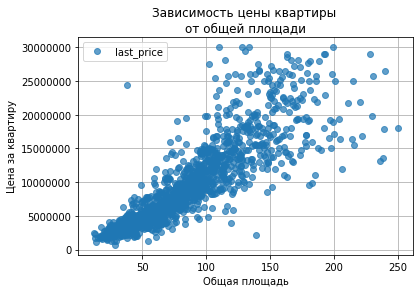

В очищенных данных корреляция общей площади и ценой квартиры равна 0.7827378213219394


In [21]:
total_area_price = good_data.pivot_table(index = 'total_area', values = 'last_price')
total_area_price.plot(grid=True, style = 'o', alpha=0.7)
plt.title('Зависимость цены квартиры \nот общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Цена за квартиру')
plt.ticklabel_format(style='plain')
plt.show()

total_area_price_corr = good_data['total_area'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция общей площади и ценой квартиры равна {total_area_price_corr}')

Мы видим по значению корреляции, что показатель меньше 1. Тем не менее, можно сказать, что чем выше общая площадь,тем выше и цена за квартиру, но это влияние слабое.

Мы видим по значению корреляции, что она выше между общей площадью и общей ценой квартиры, но показатель все равно меньше 1. Тем не менее, можно сказать, что чем выше общая площадь,тем выше и цена за квартиру.

**Зависимость цены за 1 кв м от площади кухни**

В очищенных данных корреляция площади кухни и цены за 1 кв м равна 0.311304860557697
В данных до обработки корреляция площади кухни и цены за 1 кв м равна 0.38340261940428505


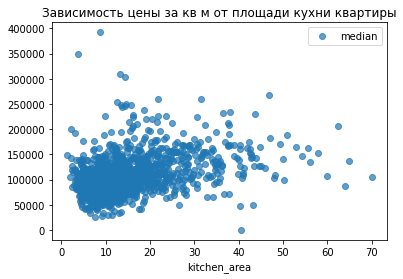

In [22]:
kitchen_area_price = good_data.pivot_table(index = 'kitchen_area', values = 'meter_price', aggfunc = ['median', 'mean'])
kitchen_area_price.columns = ['median', 'mean']
kitchen_area_price.sort_values('median', ascending = False)
kitchen_area_price.plot(y = 'median', style = 'o', alpha=0.7)
plt.title('Зависимость цены за кв м от площади кухни квартиры')

good_kitchen_area_price_corr = good_data['kitchen_area'].corr(good_data['meter_price'])
kitchen_area_price_corr = data['kitchen_area'].corr(data['meter_price'])

print(f'В очищенных данных корреляция площади кухни и цены за 1 кв м равна {good_kitchen_area_price_corr}')
print(f'В данных до обработки корреляция площади кухни и цены за 1 кв м равна {kitchen_area_price_corr}')

Мы видим, что корреляция между площадью кухни и стоимостью 1 кв м чуть выше, чем в случае с общей и жилой площадями. Тем не менее, линейная связь все равно слабая и меньше 1.

**Зависимость общей цены от площади кухни квартиры**

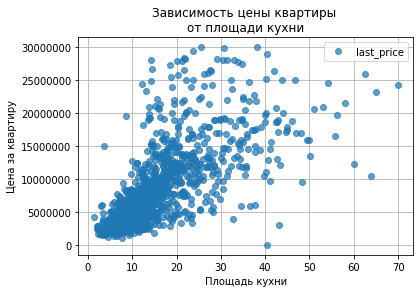

В очищенных данных корреляция между площадью кухни и ценой квартиры равна 0.6165668725623331


In [23]:
kitchen_area_price = good_data.pivot_table(index = 'kitchen_area', values = 'last_price')
kitchen_area_price.plot(grid=True, style = 'o', alpha=0.7)
plt.title('Зависимость цены квартиры \nот площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Цена за квартиру')
plt.ticklabel_format(style='plain')
plt.show()

kitchen_area_price_corr = good_data['kitchen_area'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция между площадью кухни и ценой квартиры равна {kitchen_area_price_corr}')

Согласно обновленным подсчетам, корреляция между площадью кухни и общей стоимостью квартиры чуть ниже, чем в случае с общей. При этом линейная связь все равно остается слабой и меньше 1. Можно сказать, что увеличение площади кухни незначительно влияет и на рост общей стоимости недвижимости.

**Зависимость общей цены от жилой площади квартиры**

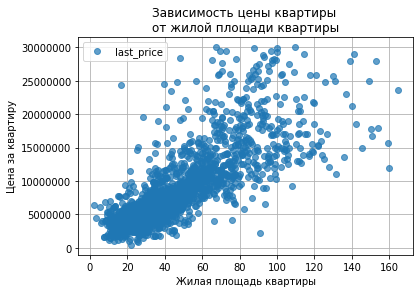

В очищенных данных корреляция между жилой площадью и ценой квартиры равна 0.6755365193506672


In [24]:
living_area_price = good_data.pivot_table(index = 'living_area', values = 'last_price')
living_area_price.plot(grid=True, style = 'o', alpha=0.7)
plt.title('Зависимость цены квартиры \nот жилой площади квартиры')
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Цена за квартиру')
plt.ticklabel_format(style='plain')
plt.show()

living_area_price_corr = good_data['living_area'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция между жилой площадью и ценой квартиры равна {living_area_price_corr}')

Корреляция между жилой площадью и ценой квартиры меньше 1, но больше, чем в случае с площадью кухни. Поэтому можно сказать, что увеличение жилой площади влияет на рост стоимости квартиры чуть больше, чем увеличение площади кухни. Тем не менее, это влияние все равно слабое.

**Зависимость цены за квартиру от количества комнат**

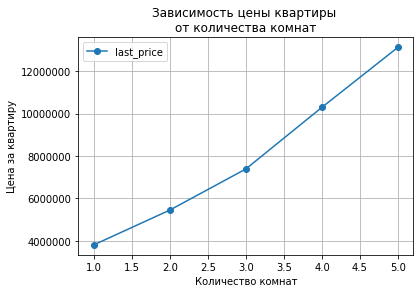

В очищенных данных корреляция количества комнат и цены за 1 кв м равна 0.482177949532043


In [25]:
rooms_price = good_data.pivot_table(index = 'rooms', values = 'last_price')
rooms_price.plot(grid=True, style = 'o-')
plt.title('Зависимость цены квартиры \nот количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена за квартиру')
plt.ticklabel_format(style='plain')
plt.show()

rooms_price_corr = good_data['rooms'].corr(good_data['last_price'])

print(f'В очищенных данных корреляция количества комнат и цены за 1 кв м равна {rooms_price_corr}')

Корреляция между количеством комнат и ценой за квартиру слабая. Тем не менее, можно сказать, что с ростом числа комнат растет и стоимость квартиры.

**Зависимость цены квартиры от этажа**

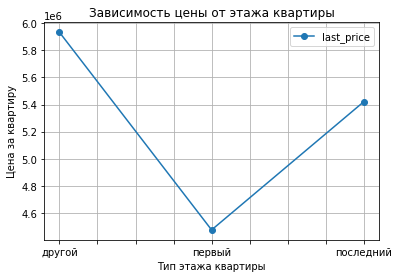

В очищенных данных корреляция количества комнат и цены за 1 кв м равна 0.08913420346538006


In [26]:
floor_category_price = good_data.pivot_table(index = 'floor_category', values = 'last_price')

floor_category_price.plot(grid=True, marker='o')
plt.title('Зависимость цены от этажа квартиры')
plt.xlabel('Тип этажа квартиры')
plt.ylabel('Цена за квартиру')
plt.show()

floor_price_corr = good_data['floor'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция количества комнат и цены за 1 кв м равна {floor_price_corr}')

Мы видим, что цены за квартиры на первом этаже ниже, чем у квартир на других этажах. При этом цена за квартиры на последнем этаже тоже дешевле, но поменьше. В целом корреляция между типом этажа и стоимостью квартиры гораздо меньше, чем у других показателей, рассмотренных выше.

**Зависимость цены квартиры от расстояния до центра**

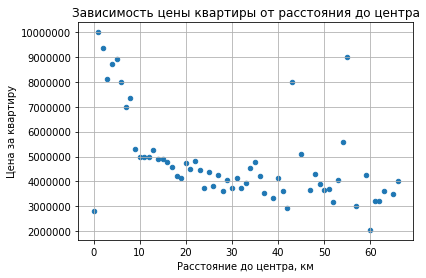

В очищенных данных корреляция между расстоянием до центра и ценой квартиры равна -0.0021851216002390034


In [27]:
centre_price = good_data.pivot_table(index='centre_distance', values='last_price', aggfunc='median').reset_index()
centre_price.plot(kind = 'scatter', y = 'last_price', x = 'centre_distance', grid=True)
plt.title('Зависимость цены квартиры от расстояния до центра')
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Цена за квартиру')
plt.ticklabel_format(style='plain')
plt.show()


centre_price_corr = good_data['cityCenters_nearest'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция между расстоянием до центра и ценой квартиры равна {centre_price_corr}')

Мы видим, что между стоимостью квартиры и близостью к центру есть связь. Чем дальше квартира расположена к центру, тем дешевле она стоит: этим объясняется отрицательный показатель корреляции.

**Зависимость цены квартиры от даты размещения**

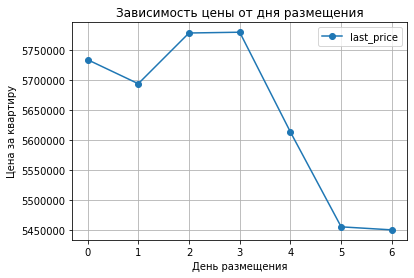

В очищенных данных корреляция дня размещения и цены квартиры равна -0.020558427805142748


In [28]:
day_price = good_data.pivot_table(index = 'day', values = 'last_price')
day_price.plot(grid=True, marker='o')
plt.title('Зависимость цены от дня размещения')
plt.ticklabel_format(style='plain')
plt.xlabel('День размещения')
plt.ylabel('Цена за квартиру')
plt.show()

day_price_corr = good_data['day'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция дня размещения и цены квартиры равна {day_price_corr}')

По графику видно, что самая низкая стоимость у объявлений, которые выставили в воскресенье, а самая высокая - у выставленных в четверг объявлений. Это можно объяснить снижением покупательской активности в выходные: мы видим, что в будние дни стоимость выставленных квартир выше. При этом нельзя сказать, что корреляция сильная: она не достигает -1 и не больше 1.

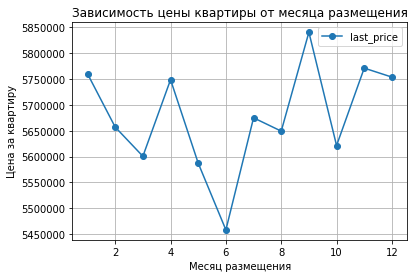

В очищенных данных корреляция месяца размещения и цены квартиры равна 0.006838739296569416


In [29]:
month_price = good_data.pivot_table(index = 'month', values = 'last_price')
month_price.plot(grid=True, marker='o')
plt.title('Зависимость цены квартиры от месяца размещения')
plt.ticklabel_format(style='plain')
plt.xlabel('Месяц размещения')
plt.ylabel('Цена за квартиру')
plt.show()

month_price_corr = good_data['month'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция месяца размещения и цены квартиры равна {month_price_corr}')

Мы видим, что худший месяц с точки зрения стоимости квартиры - август. Это можно объяснить низким сезоном, подготовкой к учебному году (как следствие, расходы на него) и отпусками. Пик активности приходится на начало делового сезона, сентябрь.

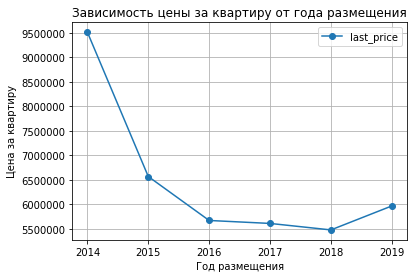

В очищенных данных корреляция месяца размещения и цены квартиры равна -0.03805561298843704


In [30]:
year_price = good_data.pivot_table(index = 'year', values = 'last_price')
year_price.plot(grid=True, marker='o')
plt.title('Зависимость цены за квартиру от года размещения')
plt.ticklabel_format(style='plain')
plt.xlabel('Год размещения')
plt.ylabel('Цена за квартиру')
plt.show()

year_price_corr = good_data['year'].corr(good_data['last_price'])
print(f'В очищенных данных корреляция месяца размещения и цены квартиры равна {year_price_corr}')

2014 год был пиковым с точки зрения стоимости за 1 кв м. Основная причина - резкий скачок курса рубля из-за мирового финансового кризиса. Начиная с 2015 года покупка жилья, по данным Ipsos Comcon (https://adindex.ru/adindex-market/4/realty/153773.phtml), перестала быть приоритетной целью для покупателей с деньгами в силу сокращения платежеспособности. Рынок откликнулся на это понижением стоимости, которое продлилось, судя по графику, вплоть до 2018 года. 

В 2018 году рынок снова стал расти (https://realty.rbc.ru/news/5c418df79a79472e03164cd1). В первую очередь это связано с ростом спроса на ипотечное кредитование и снижением стоимости кредита.

#### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.


Сперва отберем 10 населенных пунктов из good data с наибольшим числом объявлений с помощью pivot table. 
В новом датафрейме сразу посчитаем среднюю цену за 1 кв м и сразу избавимся от мультииндекса с помощью reset_index (сделаем index locality_name отдельной колонкой).

In [31]:
location = good_data.pivot_table(index = 'locality_name', 
                                 values = 'meter_price', aggfunc = ['count', 'mean']).reset_index()
location.columns = ['locality_name', 'count', 'mean_meter_price']
location = location.sort_values('count', ascending = False)
display(location.head(10))

,locality_name,count,mean_meter_price
33,Санкт-Петербург,15090,110591.325645
219,поселок Мурино,526,85029.524221
297,поселок Шушары,435,78277.935632
3,Всеволожск,392,68618.013724
32,Пушкин,366,103221.059235
13,Колпино,337,75333.295816
230,поселок Парголово,322,90448.423416
6,Гатчина,307,68746.146515
79,деревня Кудрово,283,92297.218834
4,Выборг,237,58141.909325


Больше всего объявлений в Петербурге (15,1 тысячи), Мурине (526), Шушарах (435), Всеволожске (392), Пушкине (366), Колпино (337), Парголово (322), Гатчине (307), Кудрове (283), Выборге (237). Средняя цена за 1 кв м в этих регионах колеблется от 58,1 тысячи в Выборге до 110,6 тысяч в Петербурге.

Кроме того, по таблице видим населенные пункты с самой высокой и низкой стоимостью за кв м в топ-10. Это Петербург и Выборг соответственно.

#### 6. Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.


Сперва создадим с помощью query() срез данных о недвижимости именно в Петербурге и соберем сводную таблицу по показателям дистанции до центра и цены за кв м.

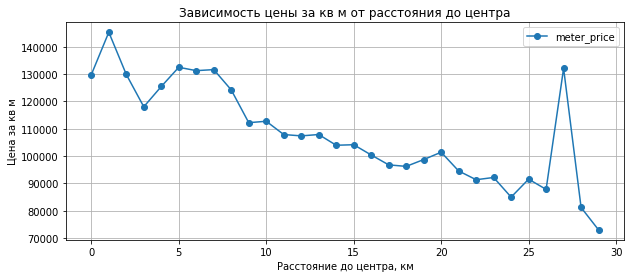

In [32]:
good_data_spb = good_data.query('locality_name == "Санкт-Петербург"')
centre_distance_data = good_data_spb.pivot_table(index = 'centre_distance', values = 'meter_price')
centre_distance_data.plot(grid=True, marker='o', figsize=(10,4))
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Цена за кв м')
plt.title('Зависимость цены за кв м от расстояния до центра')
plt.show()

Определим по графику радиус центра: мы видим, что основной тренд на снижение цены за кв м начинается после 10 км от центра. Возьмем его за границу центральной зоны. Мы видим, что после этой границы цена за кв м начинает падать вплоть до расстояния в 26 км от центра: со 112 тыс. за кв м до 87 тыс. за кв м. Затем в графике есть резкий пик на 27 км от центра: цена за кв м превышает 130 тыс. Эти данные можно связать или с наличием элитной недвижимости, которая стоит дороже обычной, за пределами города, или с аномальным значением цены в этом сегменте. 

Дальше цена резко падает: на 29 км цена за кв м снижается до 73 тыс. за кв м.

In [33]:
weird_objects_27 = good_data_spb.query('centre_distance == 27')
weird_objects_27

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,day,year,month,centre_distance,floor_category
748,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0,NaN,128,193918.92,1,2017,11,27,другой
5961,6,2250000,32.0,2018-02-27,1,2.64,2,16.5,2,False,...,NaN,0,NaN,178,70312.50,1,2018,2,27,последний


<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>
    
Скорее всего, на 27 км цену выбивает в аномалию квартира со стоимостью за 1 кв м в 194 тысячи рублей. Отбросим значение и обновим график.
</div>

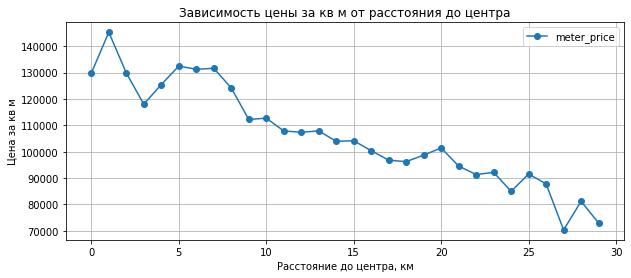

In [34]:
good_data_spb = good_data_spb.drop(labels=[748], axis=0)
centre_distance_data = good_data_spb.pivot_table(index = 'centre_distance', values = 'meter_price')
centre_distance_data.plot(grid=True, marker='o', figsize=(10,4))
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Цена за кв м')
plt.title('Зависимость цены за кв м от расстояния до центра')
plt.show()

Без аномального значения мы видим, что на 27 км цена за кв м следует общему тренду снижения при удалении от центра. 

### Общий вывод

В результате мы обработали представленный датафрейм с недвижимостью. Для этого обработали пропущенные значения и неявные дубликаты, а заодно изменили типы данных для удобства и корректности дальнейшей работы. Вот что сделали потом: 

1. Добавили в таблицу новые значения: цену за кв м жилья, ддни недели, месяцы и года размещения объявлений, добавили категории по этажам квартир. Изучили следующие параметры на наличие выбивающихся значений - площадь, цена, число комнат, высота потолков - и определили аномалии в данных параметрах. 


2. Выявили средние сроки по продажам квартир на сервисе: медианное время от публикации до снятия объявления - 90 дней, а среднее при отброшенных нулевых значениях - 180. Нормальные значения по продаже подпадают под показатель от 90 до 450 дней. Долгими можно считать объявления, которые висят более 450 дней, а быстрыми - продажи за срок менее 90 дней.


3. Определили возможную уловку продавцов: пики по снятиям публикаций приходятся на 45, 60 и 90 дней. Это может позволить им скрыть для новых покупателей, сколько дней предложение висит на сервисе, а значит, снизить сомнения по покупке из-за долго висящего объекта.


4. Узнали показатели, которые больше всего влияют на стоимость квартиры. Это расстояние до центра и этаж квартиры. Средняя цена за квартиры на первом или последнем этажах ниже, чем у квартир на других этажах. Самая дорогая недвижимость - в центре Петербурга (это радиус в 5 км). После этой границы цена за кв м начинает падать вплоть до расстояния в 28 км от центра: со 112 тыс. за кв м до 70 тыс. за кв м.

5. На стоимость квартиры влияет и ее площадь: в первую очередь общая, затем жилая площадь и площадь кухни. Корреляция тут небольшая, но связь есть: чем больше площадь, тем больше цена. Кроме того, аналогично влияет и количество комнат: с их увеличением растет и стоимость недвижимости.


6. Есть небольшая связь между ценой за кв м и временем публикации (день, месяц и год). Худший месяц для продавца по продажам недвижимости - август. Это можно объяснить низким сезоном, подготовкой к учебному году (как следствие, расходы на него) и отпусками. Пик активности приходится на начало делового сезона, сентябрь. По году: наибольшую цену за 1 кв м продавец мог получить в 2014 году. Это связано предположительно с ростом курса из-за кризиса.


**Рекомендации заказчику по сбору данных**

1. Унифицировать ввод информации по высоте потолков.
Как видно из датафрейма, часть продавцов по ошибке вместо значения в метрах вводила значение в сантиметрах. Возможно, это можно было поправить приемом только значения в метрах.

2. Создать правила для объектов с аномальными значениями и указывать причины аномалий.
Это, например, квартиры с площадью в 400 м или квартиры в 27 км от СПб с ценой за кв м в 200 тысяч рублей. Сейчас причины таких аномалий неизвестны: это может быть как человеческий фактор, так и какие-то уникальные для рынка лоты. Хотелось бы при анализе видеть ее возможную причину от менеджеров продукта.

3. Унифицировать ввод в колонках с целыми числами.
Количество этажей в доме и балконов не может быть дробным значением, а сейчас продавцы как будто могут указывать такие значения.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод